# Battle of the neighbourhoods


### Introduction to the problem

Currently living in the capital city of Poland - Warsaw a person has decided to move to the Big Apple, as he received a very fine job offer. In this case that person (let's call him Janek) wants to find a good place to live. We will need to deifne what are Janek needs.

* Safety first - Janek want to live in quite calm neighbourhood

* Office commute - Janek is a lucky person, and his new employer does not need him to be in the office very often, once a week would be enough. However public transportation is a must as Janek does not have a driving license.

* Cafe - However to work efficiently Janek needs caffeine. A lot of caffeine, so highly rated cafes in the neighbourhood is a must.

* Polish cuisine - Janek loves his family. His Grandma makes the best pork chop and pierogi in the earth, but because Janek can't get his Grandma with him than at least some Polish restaurants within a walking distance would be good.

* Italian cuisine - Pasta, Pizza, Seafood and Wine are what Janek could eat and drink all the time. Like really all the time.

Having stated 5 most important points, We will now dig in to the data to find out, what would be most suitable place for Janek.

### Data

We will be using data from several sources including:

* NYC Open Data - https://data.cityofnewyork.us/Public-Safety/NYPD-Arrest-Data-Year-to-Date-/uip8-fykc
* NYC Neigbourhood Names and GeoLocations - https://geo.nyu.edu/catalog/nyu_2451_34572
* Foursqaure API



### Planned methodology

1. Based on the NYC Open Data we will analyze which of the Districts has the lowest crime rate. We will then select it for further analysis.

2. With NYC Neighbourhood Names and GeoLocations we will create the Neighbourhoods in the District which will be selected in the first step.

3. In this step we will look for the neighbourhood which has the Cafes, Polish and Italian restaurants. Based on this we will make a selection of the place for Janek to live.

## 1. Is it safe?

Let's take a look in the NYC Open Data

In [1]:
import pandas as pd #importing pandas

df_crime = pd.read_csv('https://data.cityofnewyork.us/api/views/uip8-fykc/rows.csv?accessType=DOWNLOAD') #importing the csv
df_crime.head() #showing the first rows of the table

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude
0,206892169,12/31/2019,907.0,"IMPAIRED DRIVING,DRUG",347.0,INTOXICATED & IMPAIRED DRIVING,VTL11920U4,M,M,33,0,25-44,M,WHITE,1000916,245710,40.841085,-73.939769
1,206888084,12/31/2019,739.0,"FRAUD,UNCLASSIFIED-FELONY",112.0,THEFT-FRAUD,PL 1908301,F,Q,101,0,25-44,M,BLACK HISPANIC,1055868,156522,40.596012,-73.742116
2,206890433,12/31/2019,122.0,"HOMICIDE, NEGLIGENT, VEHICLE,",102.0,HOMICIDE-NEGLIGENT-VEHICLE,PL 1251201,F,M,23,0,18-24,M,BLACK,997462,227024,40.789803,-73.952289
3,206890441,12/31/2019,268.0,CRIMINAL MIS 2 & 3,121.0,CRIMINAL MISCHIEF & RELATED OF,PL 1450502,F,S,120,0,18-24,M,BLACK,962822,174282,40.645023,-74.077217
4,206890973,12/31/2019,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,M,25,97,25-44,M,BLACK,1004138,226326,40.787875,-73.928182


In [2]:
df_crime.shape #shape of the dataframe

(214617, 18)

We will not need of course all of the data stated in the csv. Actually we will need only the number of the crimes in each neigbhourhood. So lets count ARREST_BORO column

In [3]:
df_crimebydistrict = df_crime['ARREST_BORO'].value_counts()
crime_df = df_crimebydistrict.to_dict()
print(crime_df)

{'K': 58288, 'M': 53915, 'B': 48815, 'Q': 44567, 'S': 9032}


In [4]:
crime_df2 = pd.DataFrame.from_dict(crime_df, orient='index')
crime_df2

,0
K,58288
M,53915
B,48815
Q,44567
S,9032


We see counted info in the the dataframe. Based on the information from the NYC Open Data page: "K":"Brooklyn","M":"Manhattan", "B":"Bronx", "Q":"Queens", "S":"Staten Island". So let's clean this dataframe

In [5]:
crime_df2.reset_index(inplace = True)
crime_df2.rename(columns={"index":"District",0:"Count"}, inplace = True)
crime_df2.replace({"K":"Brooklyn","M":"Manhattan", "B":"Bronx", "Q":"Queens", "S":"Staten Island"}, inplace = True)
crime_df2

,District,Count
0,Brooklyn,58288
1,Manhattan,53915
2,Bronx,48815
3,Queens,44567
4,Staten Island,9032


As we see in the dataframe, the smallest amount of the crimes was comitted in Staten Island. In this case we select Staten Island for further analysis.

In [6]:
import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')


Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


In [7]:
address = 'Staten Island, NY'

geolocator = Nominatim(user_agent="si_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Staten Island, NY are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Staten Island, NY are 40.5834557, -74.1496048.


In [8]:
si_nyc_map = folium.Map(location=[latitude, longitude], zoom_start=12)
si_nyc_map

## 2. Neighbourhoods on Staten Island

Let's get the Neighbourhood list on Staten Island

In [9]:
# downloading the data for all neighbourhoods in NYC
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [10]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [11]:
neighbourhoods_data = newyork_data['features']

In [12]:
# define the dataframe columns
column_names = ['Borough', 'Neighbourhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighbourhoods = pd.DataFrame(columns=column_names)

In [13]:
# inserting the json data in to the created dataframe

for data in neighbourhoods_data:
    borough = neighbourhood_name = data['properties']['borough'] 
    neighbourhood_name = data['properties']['name']
        
    neighbourhood_latlon = data['geometry']['coordinates']
    neighbourhood_lat = neighbourhood_latlon[1]
    neighbourhood_lon = neighbourhood_latlon[0]
    
    neighbourhoods = neighbourhoods.append({'Borough': borough,
                                          'Neighbourhood': neighbourhood_name,
                                          'Latitude': neighbourhood_lat,
                                          'Longitude': neighbourhood_lon}, ignore_index=True)

In [14]:
#let's take a quick look

neighbourhoods.head()

,Borough,Neighbourhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [15]:
#creating a dataframe with Staten Island neighbourhood 

staten_island_data = neighbourhoods[neighbourhoods['Borough'] == 'Staten Island'].reset_index(drop=True)
staten_island_data.head()

,Borough,Neighbourhood,Latitude,Longitude
0,Staten Island,St. George,40.644982,-74.079353
1,Staten Island,New Brighton,40.640615,-74.087017
2,Staten Island,Stapleton,40.626928,-74.077902
3,Staten Island,Rosebank,40.615305,-74.069805
4,Staten Island,West Brighton,40.631879,-74.107182


In [16]:
#shape of the df will give us the number of the Neighbourhoods.

staten_island_data.shape

(63, 4)

In [17]:
# create map of Staten Island using latitude and longitude values
map_staten_island = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(staten_island_data['Latitude'], staten_island_data['Longitude'], staten_island_data['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='green',
        fill=True,
        fill_color='white',
        fill_opacity=0.7,
        parse_html=True).add_to(map_staten_island)  
    
map_staten_island

In [18]:
# Foursquare login

CLIENT_ID = 'MWMUH45FTFS1QDSXIUYX5M3VC5AT50PC214STFH5N23CILCN' # Foursquare ID
CLIENT_SECRET = 'EESSX2LZUJ1B14HRBUEYO214QTS2RMYZH53CMO243BWFZZLU' # Foursquare Secret
VERSION = '20180605' # Foursquare API version


In [19]:
LIMIT = 200
radius = 750

In [20]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [21]:
island_venues = getNearbyVenues(names=staten_island_data['Neighbourhood'],
                                   latitudes=staten_island_data['Latitude'],
                                   longitudes=staten_island_data['Longitude']
                                  )


St. George
New Brighton
Stapleton
Rosebank
West Brighton
Grymes Hill
Todt Hill
South Beach
Port Richmond
Mariner's Harbor
Port Ivory
Castleton Corners
New Springville
Travis
New Dorp
Oakwood
Great Kills
Eltingville
Annadale
Woodrow
Tottenville
Tompkinsville
Silver Lake
Sunnyside
Park Hill
Westerleigh
Graniteville
Arlington
Arrochar
Grasmere
Old Town
Dongan Hills
Midland Beach
Grant City
New Dorp Beach
Bay Terrace
Huguenot
Pleasant Plains
Butler Manor
Charleston
Rossville
Arden Heights
Greenridge
Heartland Village
Chelsea
Bloomfield
Bulls Head
Richmond Town
Shore Acres
Clifton
Concord
Emerson Hill
Randall Manor
Howland Hook
Elm Park
Manor Heights
Willowbrook
Sandy Ground
Egbertville
Prince's Bay
Lighthouse Hill
Richmond Valley
Fox Hills


In [22]:
print(island_venues.shape)
island_venues.head()

(828, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,St. George,40.644982,-74.079353,A&S Pizzeria,40.643940,-74.077626,Pizza Place
1,St. George,40.644982,-74.079353,Beso,40.643306,-74.076508,Tapas Restaurant
2,St. George,40.644982,-74.079353,Richmond County Bank Ballpark,40.645056,-74.076864,Baseball Stadium
3,St. George,40.644982,-74.079353,Staten Island September 11 Memorial,40.646767,-74.076510,Monument / Landmark
4,St. George,40.644982,-74.079353,Nike Factory Store,40.645753,-74.077702,Sporting Goods Shop


In [23]:
print('There are {} uniques categories.'.format(len(island_venues['Venue Category'].unique())))

There are 180 uniques categories.


In [24]:
island_venues['Venue Category'].unique()

array(['Pizza Place', 'Tapas Restaurant', 'Baseball Stadium',
       'Monument / Landmark', 'Sporting Goods Shop', 'Burger Joint',
       'Italian Restaurant', 'Clothing Store', 'Theater',
       'American Restaurant', 'Bar', 'Toy / Game Store', 'Art Gallery',
       'Farmers Market', 'Coffee Shop', 'Pharmacy', 'Steakhouse',
       'Donut Shop', 'Outlet Mall', 'Plaza', 'Thai Restaurant',
       'Sandwich Place', 'Deli / Bodega', 'Harbor / Marina',
       'Scenic Lookout', 'Tourist Information Center', 'Discount Store',
       'Bus Stop', 'Bowling Alley', 'Park', 'Playground',
       'Sri Lankan Restaurant', 'Asian Restaurant', 'Beer Bar',
       'Spanish Restaurant', 'Skate Park',
       'Residential Building (Apartment / Condo)', 'Mexican Restaurant',
       'Restaurant', 'New American Restaurant', 'Bank',
       'Fast Food Restaurant', 'Train Station', 'Optical Shop', 'Café',
       'Cosmetics Shop', 'Breakfast Spot', 'Motorcycle Shop',
       'Cajun / Creole Restaurant', 'Grocery St

The categories we are interrested in are: Pizza Place, Italian Restaurant, Donut Shop, Beer Bar, Eatern European Restaurant, Bagel Shop, Polish Restaurant. Those places are connected mostly with Janek's requirements

In [25]:
staten_island_venues = island_venues[island_venues['Venue Category'].isin(['Pizza Place','Italian Restaurant','Donut Shop','Beer Bar','Eastern European Restaurant','Bagel Shop', 'Polish Restaurant', 'Café', 'Coffee Shop'])]

In [26]:
staten_island_venues.reset_index(inplace = True)

In [27]:
staten_island_venues.head()

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,St. George,40.644982,-74.079353,A&S Pizzeria,40.643940,-74.077626,Pizza Place
1,6,St. George,40.644982,-74.079353,Enoteca Maria,40.641941,-74.077320,Italian Restaurant
2,10,St. George,40.644982,-74.079353,Marie's 2,40.642176,-74.076669,Italian Restaurant
3,21,St. George,40.644982,-74.079353,Starbucks,40.644745,-74.074488,Coffee Shop
4,24,St. George,40.644982,-74.079353,Dunkin',40.643821,-74.077403,Donut Shop


In [28]:
staten_island_venues.drop('index', axis=1)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,St. George,40.644982,-74.079353,A&S Pizzeria,40.643940,-74.077626,Pizza Place
1,St. George,40.644982,-74.079353,Enoteca Maria,40.641941,-74.077320,Italian Restaurant
2,St. George,40.644982,-74.079353,Marie's 2,40.642176,-74.076669,Italian Restaurant
3,St. George,40.644982,-74.079353,Starbucks,40.644745,-74.074488,Coffee Shop
4,St. George,40.644982,-74.079353,Dunkin',40.643821,-74.077403,Donut Shop
5,Stapleton,40.626928,-74.077902,The Hop Shoppe,40.629034,-74.079758,Beer Bar
6,Stapleton,40.626928,-74.077902,Bari's Pizza & Pasta,40.627296,-74.076307,Pizza Place
7,Stapleton,40.626928,-74.077902,Dunkin',40.631129,-74.076879,Donut Shop
8,Stapleton,40.626928,-74.077902,Duzer's Local Café and Market,40.628615,-74.079823,Café
9,Rosebank,40.615305,-74.069805,Pronto Pizza,40.616449,-74.067943,Pizza Place


In [29]:
staten_island_venues.groupby('Venue Category').count()

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,,
Bagel Shop,23,23,23,23,23,23,23
Beer Bar,1,1,1,1,1,1,1
Café,8,8,8,8,8,8,8
Coffee Shop,17,17,17,17,17,17,17
Donut Shop,17,17,17,17,17,17,17
Eastern European Restaurant,3,3,3,3,3,3,3
Italian Restaurant,40,40,40,40,40,40,40
Pizza Place,46,46,46,46,46,46,46
Polish Restaurant,1,1,1,1,1,1,1


In [30]:
# one hot encoding
island_onehot = pd.get_dummies(staten_island_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
island_onehot['Neighborhood'] = staten_island_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [island_onehot.columns[-1]] + list(island_onehot.columns[:-1])
island_onehot = island_onehot[fixed_columns]

island_onehot.head()

,Neighborhood,Bagel Shop,Beer Bar,Café,Coffee Shop,Donut Shop,Eastern European Restaurant,Italian Restaurant,Pizza Place,Polish Restaurant
0,St. George,0,0,0,0,0,0,0,1,0
1,St. George,0,0,0,0,0,0,1,0,0
2,St. George,0,0,0,0,0,0,1,0,0
3,St. George,0,0,0,1,0,0,0,0,0
4,St. George,0,0,0,0,1,0,0,0,0


In [31]:
island_grouped = island_onehot.groupby('Neighborhood').sum().reset_index()
island_grouped

,Neighborhood,Bagel Shop,Beer Bar,Café,Coffee Shop,Donut Shop,Eastern European Restaurant,Italian Restaurant,Pizza Place,Polish Restaurant
0,Annadale,0,0,0,0,0,0,0,2,0
1,Arden Heights,0,0,0,1,0,0,0,1,0
2,Arrochar,1,0,0,0,0,0,2,1,1
3,Bay Terrace,0,0,0,0,1,0,1,0,0
4,Bulls Head,1,0,1,1,1,0,1,4,0
5,Castleton Corners,1,0,0,0,0,0,0,3,0
6,Charleston,0,0,0,1,1,0,0,1,0
7,Chelsea,0,0,0,0,0,0,1,0,0
8,Clifton,0,0,0,0,0,1,0,1,0
9,Concord,1,0,0,1,0,0,0,0,0


In [32]:
island_grouped.loc[:,'Total']= island_grouped.sum(numeric_only=True, axis=1)

In [33]:
island_grouped

,Neighborhood,Bagel Shop,Beer Bar,Café,Coffee Shop,Donut Shop,Eastern European Restaurant,Italian Restaurant,Pizza Place,Polish Restaurant,Total
0,Annadale,0,0,0,0,0,0,0,2,0,2
1,Arden Heights,0,0,0,1,0,0,0,1,0,2
2,Arrochar,1,0,0,0,0,0,2,1,1,5
3,Bay Terrace,0,0,0,0,1,0,1,0,0,2
4,Bulls Head,1,0,1,1,1,0,1,4,0,9
5,Castleton Corners,1,0,0,0,0,0,0,3,0,4
6,Charleston,0,0,0,1,1,0,0,1,0,3
7,Chelsea,0,0,0,0,0,0,1,0,0,1
8,Clifton,0,0,0,0,0,1,0,1,0,2
9,Concord,1,0,0,1,0,0,0,0,0,2


## 3. Results

The table above presents the number of selected Venues in each Nieghbourhood. For each venue in the neighbourhood we are giving one point. Total points are in the last column. Let's visualize the data.

In [34]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.0.2


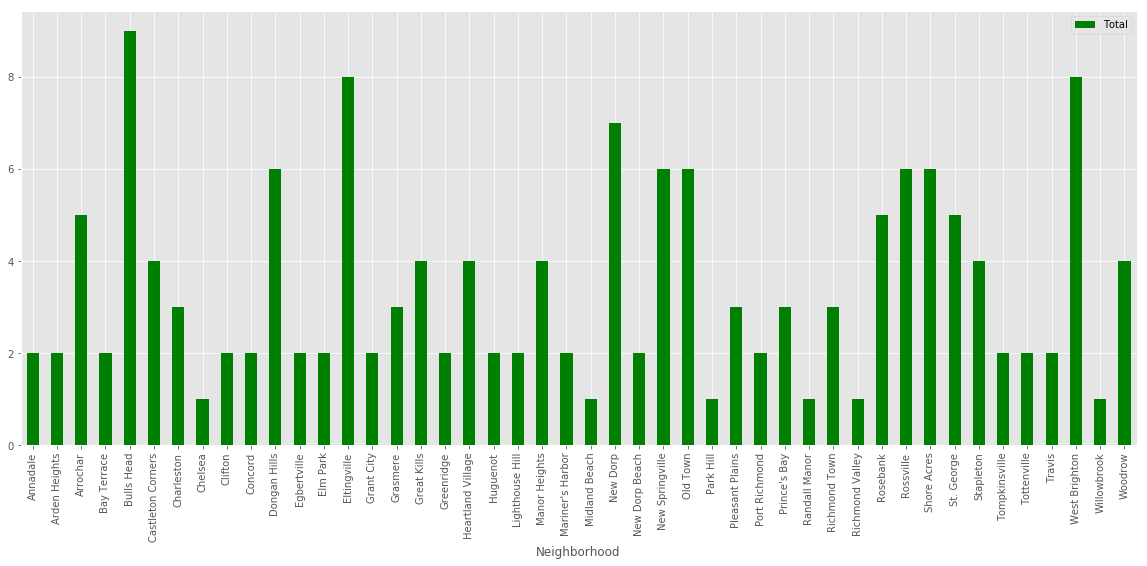

In [35]:
ax = island_grouped.plot.bar(x='Neighborhood', y='Total', rot=90, figsize=(20, 8), color='green')

## Best choices would be: Bulls Head, Eltingville, New Dorp, West Brighton.

Let's put that on the map

In [36]:
staten_island_selected = staten_island_data[staten_island_data['Neighbourhood'].isin(['Bulls Head','Eltingville','New Dorp','West Brighton'])]

In [37]:
staten_island_selected.reset_index(drop = True)

,Borough,Neighbourhood,Latitude,Longitude
0,Staten Island,West Brighton,40.631879,-74.107182
1,Staten Island,New Dorp,40.572572,-74.116479
2,Staten Island,Eltingville,40.542231,-74.164331
3,Staten Island,Bulls Head,40.609592,-74.159409


In [38]:
staten_island_selected.reset_index(inplace=True)

In [39]:
# create map of Staten Island selected Neighbourhoods
map_staten_island_selected = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(staten_island_selected['Latitude'], staten_island_selected['Longitude'], staten_island_selected['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=15,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7,
        parse_html=True).add_to(map_staten_island_selected)  
    
map_staten_island_selected

## 4. Discussion

The 4 selected neighbourhoods are selected on some contraints. It is always hard to define which will be the best, but this give us some answer to the customer expactations. We can enhance our research by checking time to get to the office, prices of the flats and so on.

## 5. Conclusion

Janek requirements was:

* Safety first - Janek want to live in quite calm neighbourhood

* Office commute - Janek is a lucky person, and his new employer does not need him to be in the office very often, once a week would be enough. However public transportation is a must as Janek does not have a driving license.

* Cafe - However to work efficiently Janek needs caffeine. A lot of caffeine, so highly rated cafes in the neighbourhood is a must.

* Polish cuisine - Janek loves his family. His Grandma makes the best pork chop and pierogi in the earth, but because Janek can't get his Grandma with him than at least some Polish restaurants within a walking distance would be good.

* Italian cuisine - Pasta, Pizza, Seafood and Wine are what Janek could eat and drink all the time. Like really all the time.

We have selected four neighbourhood which will be presented to Janek. Those are: Bulls Head, Eltingville, New Dorp, West Brighton. The next step is up to Janek, to look for a flat which will suite him the best. But that can be a totally new report, for another person. :)

Thanks for getting here. It was quite a fun! :)